In [1]:
import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import verbose
#verbose.level = 'helpful'      # one of silent, helpful, debug, debug-annoying

# taken from https://github.com/jrmontag/STLDecompose
# requires installation - pip install stldecompose
from stldecompose import decompose
# Simpler smoothing uses:
# from statsmodels.tsa.seasonal import seasonal_decompose

import geopandas as gpd

C:\Users\ajwalker\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Overall prescribing

## Import data

In [2]:
q = '''
SELECT
  p.practice,
  pct,
  p.month,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050113',items,0)) AS uti_items,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050103',items,0)) AS tetracyclines,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050108',items,0)) AS sulphonamides_trimethoprim,
  SUM(IF(SUBSTR(p.bnf_code,1,9)='0501013K0',items,0)) AS coamoxiclav,
  SUM(IF(SUBSTR(p.bnf_code,1,7)='0501021',items,0)) AS cephalosporins,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050112',items,0)) AS quinolones,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050105',items,0)) AS macrolides,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050111',items,0)) AS metroni_tini_ornidazole,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050101',items,0)) AS penicillins,
  SUM(IF(SUBSTR(p.bnf_code,1,9)='0501013K0' OR
         SUBSTR(p.bnf_code,1,7)='0501021' OR
         SUBSTR(p.bnf_code,1,6)='050112',items,0)) AS all_broad_spectrum,
  SUM(IF(SUBSTR(p.bnf_code,1,9)='0501013K0' OR
         SUBSTR(p.bnf_code,1,7)='0501021' OR
         SUBSTR(p.bnf_code,1,6) IN ('050112','050113','050103','050105','050111','050101'),items,0)) AS denom_broad_spectrum,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050110',items,0)) AS antileprotic,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050109',items,0)) AS antituberculosis,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050107',items,0)) AS some_other_antibacterials,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050104',items,0)) AS aminogylcosides,
  SUM(items) AS items,
  SUM(IF((p.bnf_code like'0501130R0%AG' OR p.bnf_code like '0501130R0%AA' OR p.bnf_code like '0501130R0%AD' 
    OR p.bnf_code LIKE '0501015P0%AB' OR p.bnf_code LIKE '0501080W0%AE'), p.quantity,0) 
    * r.percent_of_adq) AS numerator_uti_course,
   SUM(IF((p.bnf_code like '0501130R0%AG' OR p.bnf_code like '0501130R0%AA' OR p.bnf_code like '0501130R0%AD'
    OR p.bnf_code like '0501015P0%AB' OR p.bnf_code LIKE '0501080W0%AE'), p.items,0)) AS denominator_uti_course,
  ROUND(SUM(actual_cost),2) AS actual_cost,
  AVG(total_list_size) AS list_size,
  CAST(JSON_EXTRACT(MAX(star_pu), '$.oral_antibacterials_item') AS FLOAT64) AS star_pu_items,
  CAST(JSON_EXTRACT(MAX(star_pu), '$.oral_antibacterials_cost') AS FLOAT64) AS star_pu_cost
FROM
  ebmdatalab.alex.antibiotic_prescribing p
INNER JOIN
  ebmdatalab.hscic.practices prac
ON
  p.practice = prac.code
  AND prac.setting = 4
LEFT JOIN
  ebmdatalab.alex.practice_statistics_all_years_really stat
ON
  p.practice = stat.practice
  AND p.month = stat.month
LEFT JOIN
  ebmdatalab.hscic.presentation r
ON
  p.bnf_code = r.bnf_code
GROUP BY
  practice,
  pct,
  month
ORDER BY
  practice,
  month
'''

all_antibiotics = pd.read_gbq(q, GBQ_PROJECT_ID, verbose=False, dialect='standard')
all_antibiotics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698489 entries, 0 to 698488
Data columns (total 25 columns):
practice                      698489 non-null object
pct                           698489 non-null object
month                         698489 non-null datetime64[ns]
uti_items                     698489 non-null int32
tetracyclines                 698489 non-null int32
sulphonamides_trimethoprim    698489 non-null int32
coamoxiclav                   698489 non-null int32
cephalosporins                698489 non-null int32
quinolones                    698489 non-null int32
macrolides                    698489 non-null int32
metroni_tini_ornidazole       698489 non-null int32
penicillins                   698489 non-null int32
all_broad_spectrum            698489 non-null int32
denom_broad_spectrum          698489 non-null int32
antileprotic                  698489 non-null int32
antituberculosis              698489 non-null int32
some_other_antibacterials     698489 non-null 

In [5]:
pc = all_antibiotics.copy()

pc["percent_broad_spec"] = (pc.all_broad_spectrum/pc.denom_broad_spectrum).fillna(0)
# deal with nulls
pc["three_day_courses"] = (pc.numerator_uti_course/pc.denominator_uti_course).fillna(0)
pc = pc.drop(["all_broad_spectrum","denom_broad_spectrum","numerator_uti_course","denominator_uti_course","star_pu_cost","actual_cost"],axis=1)

for column in pc:
    if (pc[column].dtype == np.float64) | (pc[column].dtype == np.int32):
        pc["%s_per_starpu"%column] = pc[column]/pc["star_pu_items"]
    else:
        pc[column] = pc[column]

pc = pc.drop(["star_pu_items_per_starpu","percent_broad_spec_per_starpu","three_day_courses_per_starpu","list_size_per_starpu"],axis=1)
pc.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698489 entries, 0 to 698488
Data columns (total 35 columns):
practice                                 698489 non-null object
pct                                      698489 non-null object
month                                    698489 non-null datetime64[ns]
uti_items                                698489 non-null int32
tetracyclines                            698489 non-null int32
sulphonamides_trimethoprim               698489 non-null int32
coamoxiclav                              698489 non-null int32
cephalosporins                           698489 non-null int32
quinolones                               698489 non-null int32
macrolides                               698489 non-null int32
metroni_tini_ornidazole                  698489 non-null int32
penicillins                              698489 non-null int32
antileprotic                             698489 non-null int32
antituberculosis                         698489 non-null in

### Calculations and percentiles

In [21]:
# filter for normal practices
filtered = pc.copy().loc[(pc.list_size>1000) & (~pd.isnull(pc.star_pu_items)) & (pc["month"]>"2010-09-01") ]
filtered.head()

x1 = np.arange(0.1, 1, 0.1)
x2 = np.arange(0.01,0.1,0.01)
x3 = np.arange(0.91, 1, 0.01)
x = np.concatenate((x1,x2,x3))
pcf = filtered.groupby('month').quantile(x)
pcf = pcf.reset_index().rename(columns={"level_1": 'percentile'})
pcf.head(20)

,month,percentile,aminogylcosides,aminogylcosides_per_starpu,antileprotic,antileprotic_per_starpu,antituberculosis,antituberculosis_per_starpu,cephalosporins,cephalosporins_per_starpu,...,some_other_antibacterials,some_other_antibacterials_per_starpu,star_pu_items,sulphonamides_trimethoprim,sulphonamides_trimethoprim_per_starpu,tetracyclines,tetracyclines_per_starpu,three_day_courses,uti_items,uti_items_per_starpu
0,2010-10-01,0.10,0.0,0.0,0.0,0.000000,0.0,0.000000,2.0,0.000945,...,0.0,0.000000,1285.021141,8.0,0.004543,7.0,0.003823,4.863636,1.0,0.000611
1,2010-10-01,0.20,0.0,0.0,0.0,0.000000,0.0,0.000000,5.0,0.001730,...,0.0,0.000000,1741.449384,13.0,0.006139,12.0,0.005153,5.367647,3.0,0.001158
2,2010-10-01,0.30,0.0,0.0,0.0,0.000000,0.0,0.000000,7.0,0.002475,...,0.0,0.000000,2227.098062,18.0,0.007332,16.0,0.006263,5.709112,5.0,0.001695
3,2010-10-01,0.40,0.0,0.0,0.0,0.000000,0.0,0.000000,10.0,0.003199,...,0.0,0.000000,2781.836536,24.0,0.008284,22.0,0.007231,6.023256,7.0,0.002217
4,2010-10-01,0.50,0.0,0.0,0.0,0.000000,0.0,0.000000,13.0,0.003978,...,0.0,0.000000,3393.865396,31.0,0.009155,28.0,0.008276,6.333333,9.0,0.002746
5,2010-10-01,0.60,0.0,0.0,0.0,0.000000,0.0,0.000000,18.0,0.004929,...,0.0,0.000000,4050.610752,37.0,0.010040,35.0,0.009293,6.633929,12.0,0.003344
6,2010-10-01,0.70,0.0,0.0,0.0,0.000000,0.0,0.000000,23.0,0.006144,...,1.0,0.000175,4799.792600,47.0,0.010960,43.0,0.010572,7.000000,16.0,0.003982
7,2010-10-01,0.80,0.0,0.0,0.0,0.000000,1.0,0.000214,31.0,0.007748,...,1.0,0.000300,5735.567645,57.0,0.012084,55.0,0.012223,7.394928,21.0,0.004818
8,2010-10-01,0.90,0.0,0.0,1.0,0.000264,2.0,0.000517,45.0,0.010852,...,2.0,0.000505,7006.119633,74.0,0.013820,73.0,0.014927,8.154009,30.0,0.006223
9,2010-10-01,0.01,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,743.201644,2.0,0.001234,1.0,0.001103,3.461538,0.0,0.000000


## Practice level plots

### Without smoothing

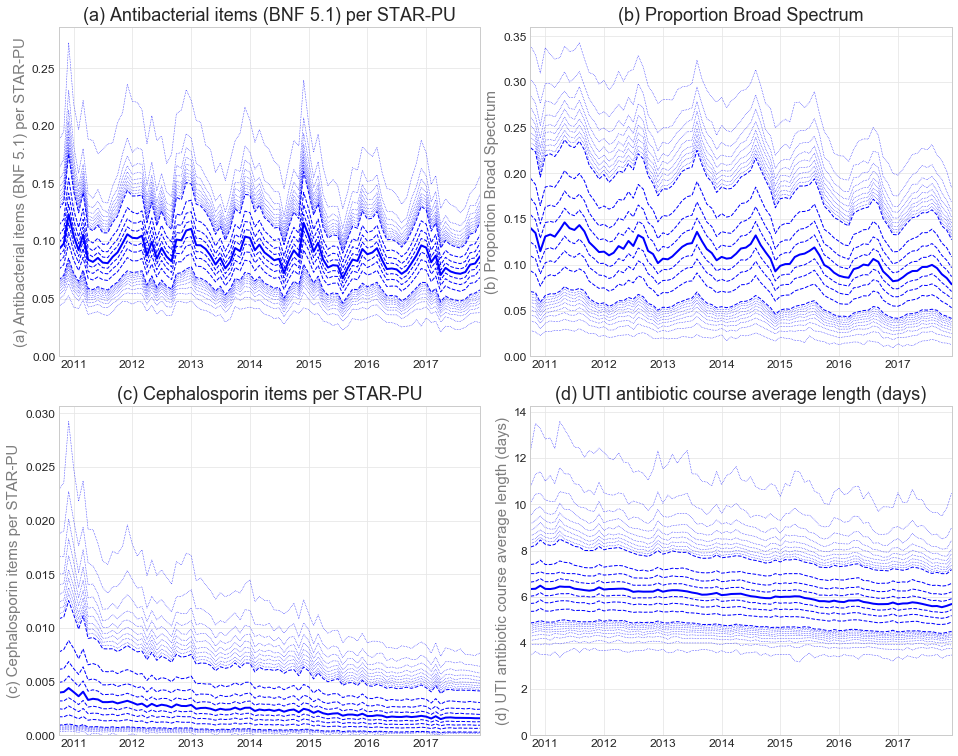

In [22]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.sort_values(by=["month"])#,"drug"])
dfp['month'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month']]

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'items_per_starpu',0,0,'(a) Antibacterial items (BNF 5.1) per STAR-PU'), 
     (1,'percent_broad_spec',0,1,'(b) Proportion Broad Spectrum'),
     (2,'cephalosporins_per_starpu',1,0,'(c) Cephalosporin items per STAR-PU'),
     (3,'three_day_courses',1,1, '(d) UTI antibiotic course average length (days)')]
x = pd.Series(x)

fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        if decile == .5:
            ax.plot(data["dates"],data[i[1]],'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],data[i[1]],'b:',linewidth=0.6)
        else:
            #print (data)
            ax.plot(data["dates"],data[i[1]],'b--',linewidth=1)
    #if  i[3]%2==0:    # set y axis title only for charts in leftmost column
    ax.set_ylabel(i[4], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.12,hspace = 0.15)
plt.savefig('practice_deciles_no_smooth.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

### WIth smoothing

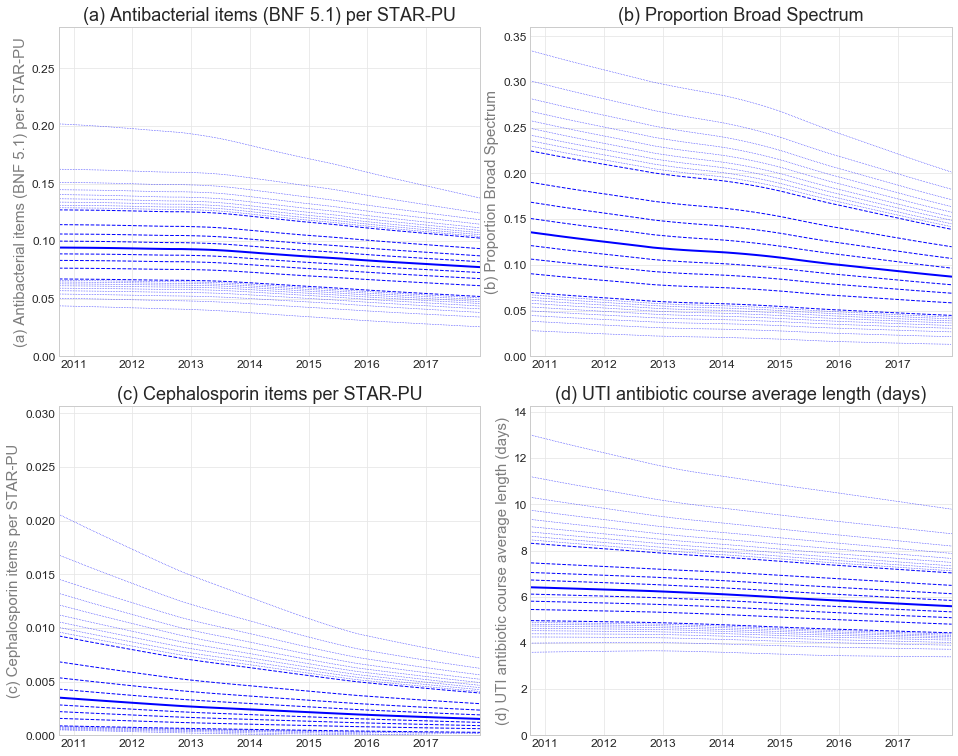

In [23]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.sort_values(by=["month"])#,"drug"])
dfp['month_str'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month_str']]

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'items_per_starpu',0,0,'(a) Antibacterial items (BNF 5.1) per STAR-PU'), 
     (1,'percent_broad_spec',0,1,'(b) Proportion Broad Spectrum'),
     (2,'cephalosporins_per_starpu',1,0,'(c) Cephalosporin items per STAR-PU'),
     (3,'three_day_courses',1,1, '(d) UTI antibiotic course average length (days)')]
x = pd.Series(x)

fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        #data.info()
        # for smoothing, dataframe needs to be non-missing and have a DateTime index
        #data = data.dropna()
        data = data.set_index('month')
        res = data[[i[1]]]
        #res = seasonal_decompose(res, model='additive') # cruder smoothing
        res = decompose(res, period=12, lo_frac=0.6, lo_delta=0.0)
        res = res.trend
        
        if decile == .5:
            ax.plot(data["dates"],res,'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],res,'b:',linewidth=0.6)
        else:
            #print (data)
            ax.plot(data["dates"],res,'b--',linewidth=1)
    #if  i[3]%2==0:    # set y axis title only for charts in leftmost column
    ax.set_ylabel(i[4], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.12,hspace = 0.15)
plt.savefig('practice_deciles_smooth.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

## CCG level

In [24]:
# remove practices with no STAR-PU
pc_ccg =  all_antibiotics.copy().loc[~pd.isnull(pc.star_pu_items) & (pc["month"]>"2010-09-01") ]
# group to CCGs
pc_ccg = pc_ccg.groupby(['pct','month'],as_index=False).sum()

pc_ccg["percent_broad_spec"] = (pc_ccg.all_broad_spectrum/pc_ccg.denom_broad_spectrum).fillna(0)
# deal with nulls
pc_ccg["three_day_courses"] = (pc_ccg.numerator_uti_course/pc_ccg.denominator_uti_course).fillna(0)
pc_ccg = pc_ccg.drop(["all_broad_spectrum","denom_broad_spectrum","numerator_uti_course","denominator_uti_course","star_pu_cost","actual_cost"],axis=1)

for column in pc_ccg:
    if (pc_ccg[column].dtype == np.float64) | (pc_ccg[column].dtype == np.int32):
        pc_ccg["%s_per_starpu"%column] = pc_ccg[column]/pc_ccg["star_pu_items"]
    else:
        pc_ccg[column] = pc_ccg[column]

pc_ccg = pc_ccg.groupby('month').quantile(x)
pc_ccg = pc_ccg.reset_index().rename(columns={"level_1": 'percentile'})

pc_ccg.head(9)

,month,percentile,aminogylcosides,aminogylcosides_per_starpu,antileprotic,antileprotic_per_starpu,antituberculosis,antituberculosis_per_starpu,cephalosporins,cephalosporins_per_starpu,...,star_pu_items,star_pu_items_per_starpu,sulphonamides_trimethoprim,sulphonamides_trimethoprim_per_starpu,tetracyclines,tetracyclines_per_starpu,three_day_courses,three_day_courses_per_starpu,uti_items,uti_items_per_starpu
0,2010-10-01,0.1,0.0,0.000000,0.0,0.000018,0.3,0.000026,23.2,0.002558,...,3121.090068,1.0,38.0,0.006507,39.2,0.005738,5.642266,0.000027,10.9,0.001818
1,2010-10-01,0.2,0.0,0.000000,3.0,0.000034,4.6,0.000057,273.2,0.002907,...,70507.214552,1.0,640.8,0.007895,600.4,0.006958,5.972369,0.000036,184.8,0.002297
2,2010-10-01,0.3,1.0,0.000007,5.0,0.000046,9.0,0.000088,385.5,0.003495,...,92192.588198,1.0,835.0,0.008848,711.0,0.007849,6.148594,0.000041,239.5,0.002616
3,2010-10-01,0.4,1.0,0.000011,7.0,0.000057,11.0,0.000103,478.8,0.004187,...,107201.957923,1.0,933.6,0.009351,844.8,0.008431,6.280731,0.000048,297.8,0.002906
4,2010-10-01,0.5,2.0,0.000016,9.0,0.000064,15.0,0.000120,575.5,0.004836,...,119229.344369,1.0,1105.5,0.009827,987.5,0.009149,6.417230,0.000053,349.5,0.003187
5,2010-10-01,0.6,3.0,0.000023,10.0,0.000077,18.0,0.000141,702.2,0.005936,...,136326.700801,1.0,1226.8,0.010343,1127.4,0.009857,6.522719,0.000059,424.2,0.003491
6,2010-10-01,0.7,4.0,0.000028,11.1,0.000090,24.1,0.000165,809.4,0.006940,...,154394.486686,1.0,1503.8,0.010844,1357.4,0.010513,6.636703,0.000070,524.1,0.003881
7,2010-10-01,0.8,5.0,0.000036,15.0,0.000111,29.4,0.000198,975.2,0.007906,...,178267.333735,1.0,1788.2,0.011271,1778.2,0.011484,6.758487,0.000086,645.0,0.004318
8,2010-10-01,0.9,8.0,0.000055,19.7,0.000137,40.0,0.000254,1359.0,0.009766,...,232987.761724,1.0,2330.6,0.012065,2347.6,0.013893,7.032700,0.000204,931.8,0.005126


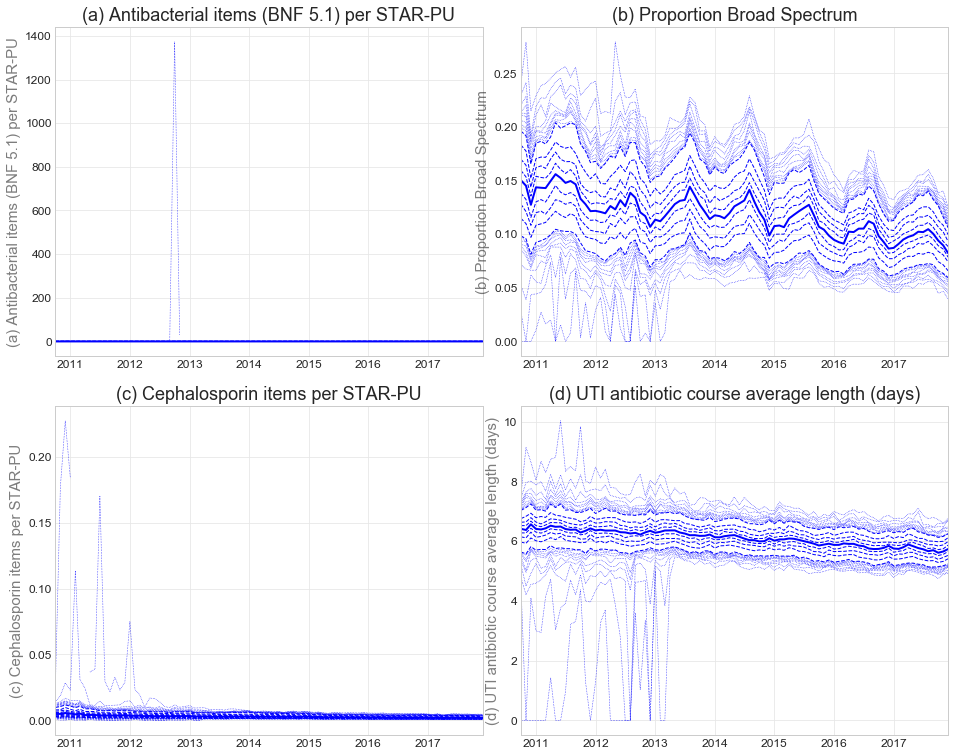

In [25]:
dfp = pc_ccg.sort_values(by=["month"])#,"drug"])
dfp['month'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month']]
x = pd.Series(x)

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'items_per_starpu',0,0,'(a) Antibacterial items (BNF 5.1) per STAR-PU'), 
     (1,'percent_broad_spec',0,1,'(b) Proportion Broad Spectrum'),
     (2,'cephalosporins_per_starpu',1,0,'(c) Cephalosporin items per STAR-PU'),
     (3,'three_day_courses',1,1, '(d) UTI antibiotic course average length (days)')]

fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        if decile == .5:
            ax.plot(data["dates"],data[i[1]],'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],data[i[1]],'b:',linewidth=0.6)
        else:
            #print (data)
            ax.plot(data["dates"],data[i[1]],'b--',linewidth=1)
    if  i[3]%2==0:    # set y axis title only for charts in leftmost column
        ax.set_ylabel('Antibacterial items/cost (BNF 5.1) per STAR-PU', size =15, alpha=0.6)
    ax.set_ylabel(i[4], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    #ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.09,hspace = 0.15)
#plt.savefig('ccg_deciles.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

# MAPS

In [26]:
#aggregate over last year
ccg_last_year =  all_antibiotics.copy().loc[~pd.isnull(pc.star_pu_items) & (pc["month"] >='2016-12-01') ]
#ccg_last_year = all_antibiotics_ccg.loc[all_antibiotics_ccg.month]
ccg_last_year = ccg_last_year.groupby('pct').sum()

ccg_last_year["percent_broad_spec"] = (ccg_last_year.all_broad_spectrum/ccg_last_year.denom_broad_spectrum).fillna(0)
# deal with nulls
ccg_last_year["three_day_courses"] = (ccg_last_year.numerator_uti_course/ccg_last_year.denominator_uti_course).fillna(0)
ccg_last_year = ccg_last_year.drop(["all_broad_spectrum","denom_broad_spectrum","numerator_uti_course","denominator_uti_course","star_pu_cost","actual_cost"],axis=1)

for column in ccg_last_year:
    if (ccg_last_year[column].dtype == np.float64) | (ccg_last_year[column].dtype == np.int32):
        ccg_last_year["%s_per_starpu"%column] = ccg_last_year[column]/ccg_last_year["star_pu_items"]
    else:
        ccg_last_year[column] = ccg_last_year[column]
ccg_last_year = ccg_last_year.drop(["star_pu_items_per_starpu","percent_broad_spec_per_starpu","three_day_courses_per_starpu","list_size_per_starpu"],axis=1)

ccg_last_year

,uti_items,tetracyclines,sulphonamides_trimethoprim,coamoxiclav,cephalosporins,quinolones,macrolides,metroni_tini_ornidazole,penicillins,antileprotic,...,cephalosporins_per_starpu,quinolones_per_starpu,macrolides_per_starpu,metroni_tini_ornidazole_per_starpu,penicillins_per_starpu,antileprotic_per_starpu,antituberculosis_per_starpu,some_other_antibacterials_per_starpu,aminogylcosides_per_starpu,items_per_starpu
pct,,,,,,,,,,,,,,,,,,,,,
00C,7039,10754,6749,1456,1699,1358,10539,1242,30093,64,...,0.002104,0.001682,0.013052,0.001538,0.037269,0.000079,0.000026,0.000645,0.000010,0.086898
00D,25348,35992,16571,3825,4262,2838,27904,4585,97098,366,...,0.001941,0.001293,0.012710,0.002088,0.044227,0.000167,0.000056,0.000692,0.000008,0.098784
00J,18152,30497,15014,4060,4250,2613,19088,3168,82374,258,...,0.002221,0.001365,0.009975,0.001655,0.043045,0.000135,0.000047,0.000724,0.000014,0.092568
00K,17640,30564,18925,4345,6791,2783,23586,4573,96749,150,...,0.003108,0.001274,0.010794,0.002093,0.044279,0.000069,0.000068,0.000400,0.000004,0.093089
00L,26756,44211,21401,9174,4425,2594,27929,2905,104235,422,...,0.001770,0.001038,0.011172,0.001162,0.041696,0.000169,0.000126,0.000595,0.000027,0.094829
00M,19500,32313,19861,7456,8856,3444,22529,4566,106930,228,...,0.004081,0.001587,0.010383,0.002104,0.049281,0.000105,0.000176,0.000639,0.000008,0.101568
00N,11112,18408,12453,2765,3319,1412,11247,2213,49392,44,...,0.002860,0.001217,0.009692,0.001907,0.042565,0.000038,0.000064,0.000549,0.000038,0.095289
00P,17524,31543,18269,7051,10522,2245,27159,3668,88547,215,...,0.004997,0.001066,0.012899,0.001742,0.042054,0.000102,0.000119,0.000751,0.000010,0.095868
00Q,9831,12241,8813,2797,3456,1346,14726,2183,58450,115,...,0.002826,0.001101,0.012043,0.001785,0.047799,0.000094,0.000060,0.000182,0.000035,0.091391


In [27]:
# join to geographical data
map_data = ccg_last_year.reset_index()
names = pd.read_csv('ccg_for_map.csv')
names = names.rename(columns={"CCG17CDH":"code","CCG17NM":"name"})
map_data = map_data.merge(names[['code','name']],left_on="pct",right_on="code")
map_data['name'] = map_data['name'].str.upper()
map_data['name'] = map_data["name"].str.replace("&","AND")
map_data = map_data.set_index('name')
#map_data = map_data.round(0)
map_data.head() # 207 rows

,pct,uti_items,tetracyclines,sulphonamides_trimethoprim,coamoxiclav,cephalosporins,quinolones,macrolides,metroni_tini_ornidazole,penicillins,...,quinolones_per_starpu,macrolides_per_starpu,metroni_tini_ornidazole_per_starpu,penicillins_per_starpu,antileprotic_per_starpu,antituberculosis_per_starpu,some_other_antibacterials_per_starpu,aminogylcosides_per_starpu,items_per_starpu,code
name,,,,,,,,,,,,,,,,,,,,,
NHS DARLINGTON CCG,00C,7039,10754,6749,1456,1699,1358,10539,1242,30093,...,0.001682,0.013052,0.001538,0.037269,0.000079,0.000026,0.000645,0.000010,0.086898,00C
"NHS DURHAM DALES, EASINGTON AND SEDGEFIELD CCG",00D,25348,35992,16571,3825,4262,2838,27904,4585,97098,...,0.001293,0.012710,0.002088,0.044227,0.000167,0.000056,0.000692,0.000008,0.098784,00D
NHS NORTH DURHAM CCG,00J,18152,30497,15014,4060,4250,2613,19088,3168,82374,...,0.001365,0.009975,0.001655,0.043045,0.000135,0.000047,0.000724,0.000014,0.092568,00J
NHS HARTLEPOOL AND STOCKTON-ON-TEES CCG,00K,17640,30564,18925,4345,6791,2783,23586,4573,96749,...,0.001274,0.010794,0.002093,0.044279,0.000069,0.000068,0.000400,0.000004,0.093089,00K
NHS NORTHUMBERLAND CCG,00L,26756,44211,21401,9174,4425,2594,27929,2905,104235,...,0.001038,0.011172,0.001162,0.041696,0.000169,0.000126,0.000595,0.000027,0.094829,00L


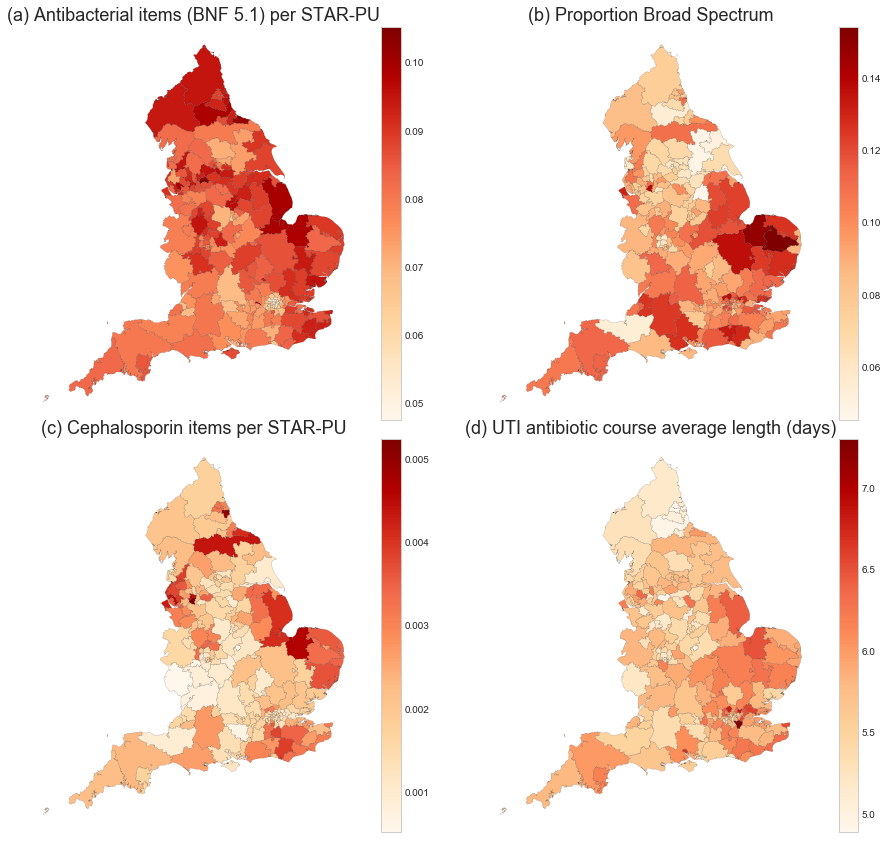

In [ ]:
# from our API https://openprescribing.net/api/1.0/org_location/?org_type=ccg
ccgs = gpd.read_file('ccgs.json').set_index('name')

ccgs = ccgs[~ccgs['geometry'].isnull()]  # remove ones without geometry - these are federations rather than individual CCGs
gdf = ccgs.join(map_data)

# set sort order of measures manually, and add grid refs to position each subplot:
s = [(0,'items_per_starpu',0,0,'(a) Antibacterial items (BNF 5.1) per STAR-PU'), 
     (1,'percent_broad_spec',0,1,'(b) Proportion Broad Spectrum'),
     (2,'cephalosporins_per_starpu',1,0,'(c) Cephalosporin items per STAR-PU'),
     (3,'three_day_courses',1,1, '(d) UTI antibiotic course average length (days)')]

fig = plt.figure(figsize=(16,30))
gs = gridspec.GridSpec(4,2)  # grid layout for subplots

for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf.plot(ax=ax,column=i[1],  edgecolor='black', linewidth=0.1, legend=True, cmap='OrRd')
    ax.set_aspect(1.63)
    ax.set_title(i[4],size = 18)
    plt.axis('off')

plt.subplots_adjust(wspace = 0.05,hspace = 0.05)
plt.savefig('maps.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

# Additional plots for appendices

In [ ]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.sort_values(by=["month"])#,"drug"])
dfp['month_str'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month_str']]

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'aminogylcosides_per_starpu',0,0,'Aminogylcosides per STAR-PU'), 
     (1,'antileprotic_per_starpu',0,1,'Antileprotic per STAR-PU'),
     (2,'cephalosporins_per_starpu',1,0,'Cephalosporins per STAR-PU'),
     (3,'coamoxiclav_per_starpu',1,1, 'Coamoxiclav per STAR-PU'),
     (4,'macrolides_per_starpu',2,0, 'Macrolides per STAR-PU'),
     (5,'metroni_tini_ornidazole_per_starpu',2,1, 'Metronidazole and tinidazole per STAR-PU'),
     (6,'quinolones_per_starpu',3,0, 'Quinolones per STAR-PU'),
     (7,'some_other_antibacterials_per_starpu',3,1, 'Some other antibacterials per STAR-PU'),
     (8,'sulphonamides_trimethoprim_per_starpu',4,0, 'Sulphonamides and trimethoprim per STAR-PU'),
     (9,'tetracyclines_per_starpu',4,1, 'Tetracyclines per STAR-PU'),
     (10,'uti_items_per_starpu',5,0, 'UTI items per STAR-PU')
    ]
x = pd.Series(x)

fig = plt.figure(figsize=(16,35)) 
gs = gridspec.GridSpec(6,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        #data.info()
        # for smoothing, dataframe needs to be non-missing and have a DateTime index
        #data = data.dropna()
        data = data.set_index('month')
        res = data[[i[1]]]
        #res = seasonal_decompose(res, model='additive') # cruder smoothing
        #res = decompose(res, period=12, lo_frac=0.6, lo_delta=0.0)
        #res = res.trend
        
        if decile == .5:
            ax.plot(data["dates"],res,'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],res,'b:',linewidth=0.6)
        else:
            #print (data)
            ax.plot(data["dates"],res,'b--',linewidth=1)
    #if  i[3]%2==0:    # set y axis title only for charts in leftmost column
    ax.set_ylabel(i[4], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.16,hspace = 0.15)
plt.savefig('practice_deciles_appendices.png', format='png', dpi=300,bbox_inches='tight')
plt.show()